In [2]:
import bnlearn

# Load the asia model
# asia = bnlearn.import_example('asia')
# X = asia.drop(columns=['dysp'])
# Y = asia['dysp']

# Load the alarm model
alarm = bnlearn.import_example('alarm')
X = alarm.drop(columns=['BP'])
Y = alarm['BP']

[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.


In [3]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Train a logistic regression model

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Initialize the logistic regression model
log_reg = LogisticRegression(random_state=0)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, Y_train)

# Get the best model
model = grid_search.best_estimator_

In [5]:
# Evaluate the model for accuracy, precision, recall, and F1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_pred = model.predict(X_test)
lr_accuracy = accuracy_score(Y_test, Y_pred)
lr_precision = precision_score(Y_test, Y_pred, average='weighted')
lr_recall = recall_score(Y_test, Y_pred, average='weighted')
lr_f1 = f1_score(Y_test, Y_pred, average='weighted')
print('Logistic Regression Metrics:')
print(f'Accuracy: {lr_accuracy:.2f}')
print(f'Precision: {lr_precision:.2f}')
print(f'Recall: {lr_recall:.2f}')
print(f'F1 Score: {lr_f1:.2f}')

Logistic Regression Metrics:
Accuracy: 0.81
Precision: 0.79
Recall: 0.81
F1 Score: 0.79


In [24]:
# Train an XGBoost model
from xgboost import XGBClassifier
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(random_state=0)

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search_xgb.fit(X_train, Y_train)

# Get the best model
model = grid_search_xgb.best_estimator_

In [25]:
# Evaluate the model for accuracy, precision, recall, and F1 score
Y_pred = model.predict(X_test)
xbg_accuracy = accuracy_score(Y_test, Y_pred)
xbg_precision = precision_score(Y_test, Y_pred, average='weighted')
xbg_recall = recall_score(Y_test, Y_pred, average='weighted')
xbg_f1 = f1_score(Y_test, Y_pred, average='weighted')
print('XGBoost Metrics:')
print('Accuracy:', xbg_accuracy)
print('Precision:', xbg_precision)
print('Recall:', xbg_recall)
print('F1 score:', xbg_f1)

XGBoost Metrics:
Accuracy: 0.829
Precision: 0.8245818450643726
Recall: 0.829
F1 score: 0.8182576080769965


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Convert the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)  # Use long for class indices
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)

# Create a DataLoader
train_data = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)  # Output size = num_classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation; logits are passed to CrossEntropyLoss
        return x

# Train the model
def train_dnn(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # CrossEntropyLoss handles logits + class indices
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

# Define the parameter grid for optimization
param_grid_dnn = {
    'hidden_dim': [32, 64, 128],
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64]
}
# Function to perform grid search for DNN with progress bar
def grid_search_dnn(param_grid, input_dim, num_classes, X_train, Y_train, epochs=100):
    best_model = None
    best_score = 0
    best_params = {}
    
    total_combinations = len(param_grid['hidden_dim']) * len(param_grid['lr']) * len(param_grid['batch_size'])
    progress_bar = tqdm(total=total_combinations, desc="Grid Search Progress")
    
    for hidden_dim in param_grid['hidden_dim']:
        for lr in param_grid['lr']:
            for batch_size in param_grid['batch_size']:
                # Create DataLoader with current batch size
                train_data = TensorDataset(X_train, Y_train)
                train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                
                # Initialize the model, criterion, and optimizer
                model = DNN(input_dim, hidden_dim, num_classes)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)
                
                # Train the model
                train_dnn(model, train_loader, criterion, optimizer, epochs)
                
                # Evaluate the model
                Y_pred = evaluate_dnn(model, X_test_tensor)
                accuracy = accuracy_score(Y_test_tensor, Y_pred)
                
                # Update best model if current model is better
                if accuracy > best_score:
                    best_score = accuracy
                    best_model = model
                    best_params = {'hidden_dim': hidden_dim, 'lr': lr, 'batch_size': batch_size}
                
                progress_bar.update(1)
    
    progress_bar.close()
    return best_model, best_params, best_score

# Evaluate the model
def evaluate_dnn(model, X_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        preds = torch.argmax(outputs, dim=1)  # Get class predictions
        return preds


# Initialize the model
input_dim = X_train_tensor.shape[1]  # Number of features
hidden_dim = 64  # Hidden layer size
num_classes = len(Y_train.unique())  # Number of unique classes in the target
model = DNN(input_dim, hidden_dim, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_params = {'hidden_dim': 32, 'lr': 0.01, 'batch_size': 32}

# Perform grid search
model, best_params, best_score = grid_search_dnn(param_grid_dnn, input_dim, num_classes, X_train_tensor, Y_train_tensor, epochs=100)


Grid Search Progress: 100%|██████████| 27/27 [07:42<00:00, 17.12s/it]


In [18]:
# Evaluate the model for accuracy, precision, recall, and F1 score
Y_pred = evaluate_dnn(model, X_test_tensor)
dnn_accuracy = accuracy_score(Y_test_tensor, Y_pred)
dnn_precision = precision_score(Y_test_tensor, Y_pred, average='weighted')
dnn_recall = recall_score(Y_test_tensor, Y_pred, average='weighted')
dnn_f1 = f1_score(Y_test_tensor, Y_pred, average='weighted')
print('DNN Metrics:')
print('Accuracy:', dnn_accuracy)
print('Precision:', dnn_precision)
print('Recall:', dnn_recall)
print('F1 score:', dnn_f1)
print('Best Parameters:', best_params)

DNN Metrics:
Accuracy: 0.8315
Precision: 0.8299494276141282
Recall: 0.8315
F1 score: 0.8176021285798359
Best Parameters: {'hidden_dim': 32, 'lr': 0.01, 'batch_size': 32}


In [ ]:
import torch_geometric as tg
from torch_geometric.utils import from_networkx
import networkx as nx

# Load the Alarm DAG
DAG = bnlearn.import_DAG('alarm')
adj_matrix = DAG['adjmat']

# Convert adjacency matrix to edge list
edges = [(parent, child) for child, parents in adj_matrix.items() for parent in parents.keys() if parents[parent]]
    
# Create a NetworkX graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Convert the NetworkX graph to a PyTorch Geometric data object
data = from_networkx(G)

# Add features and labels to the PyTorch Geometric data object
data.x = torch.tensor(X_train.values, dtype=torch.float32)
data.y = torch.tensor(Y_train.values, dtype=torch.long)  # Integer class indices

# Define the GNN model for multi-class classification
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GNN, self).__init__()
        self.conv1 = tg.nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = tg.nn.GCNConv(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, num_classes)  # Output size matches number of classes

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.linear(x)  # Output logits for CrossEntropyLoss
        return x

# Train the GNN model
def train_gnn(model, data, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)  # Forward pass
        loss = criterion(out, data.y)  # CrossEntropyLoss expects logits + class indices
        loss.backward()
        optimizer.step()

# Evaluate the GNN model
def evaluate_gnn(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)  # Forward pass
        preds = torch.argmax(out, dim=1)  # Class with highest logit
        return preds
    
def grid_search_gnn(param_grid, input_dim, num_classes, data, epochs=100):
    best_params = {}
    best_score = 0
    best_model = None
    
    total_combinations = len(param_grid['hidden_dim']) * len(param_grid['lr']) * len(param_grid['batch_size'])
    progress_bar = tqdm(total=total_combinations, desc="Grid Search Progress")
    
    for hidden_dim in param_grid['hidden_dim']:
        for lr in param_grid['lr']:
            for batch_size in param_grid['batch_size']:
                
                # Initialize the model, criterion, and optimizer
                model = GNN(input_dim, hidden_dim, num_classes)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)
                
                # Train the model
                train_gnn(model, data, criterion, optimizer, epochs)
                
                # Evaluate the model
                Y_pred = evaluate_gnn(model, data)
                accuracy = accuracy_score(Y_train, Y_pred)
                
                # Update best model if current model is better
                if accuracy > best_score:
                    best_score = accuracy
                    best_model = model
                    best_params = {'hidden_dim': hidden_dim, 'lr': lr, 'batch_size': batch_size}
                
                progress_bar.update(1)
    
    return best_model, best_params, best_score

# Define the parameter grid for optimization
param_grid_gnn = {
    'hidden_dim': [32, 64, 128],
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64]
}

# Initialize the GNN model, loss function, and optimizer
input_dim = X_train.shape[1]  # Number of features
num_classes = len(Y_train.unique())  # Number of classes in the target variable
best_params = {'hidden_dim': 128, 'lr': 0.01, 'batch_size': 64}

# Train the GNN model
model, best_params, best_score = grid_search_gnn(param_grid_gnn, input_dim, num_classes, data, epochs=100)

[bnlearn] >Import <alarm>
[bnlearn] >Loading bif file </opt/anaconda3/envs/part-ii-project/lib/python3.12/site-packages/datazets/data/alarm.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [BP] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HREKG] does not add up to 1 but is: [[0.9999999 0.9999999 1.       ]
 [0.9999999 1.        1.       ]]
[bnlearn] >CPD [HRSAT] does not add up to 1 but is: [[0.9999999 0.9999999 1.       ]
 [0.9999999 1.        1.       ]]
[bnlearn] >CPD [PRESS] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


Grid Search Progress: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


In [21]:
# Evaluate the GNN
# Add features and labels for the test data
test_data = data.clone()  # Clone the structure of the training data
test_data.x = torch.tensor(X_test.values, dtype=torch.float32)
test_data.y = torch.tensor(Y_test.values, dtype=torch.long)

# Evaluate the GNN model on the test set
Y_pred = evaluate_gnn(model, test_data)
gnn_accuracy = accuracy_score(Y_test, Y_pred)
gnn_precision = precision_score(Y_test, Y_pred, average='weighted')
gnn_recall = recall_score(Y_test, Y_pred, average='weighted')
gnn_f1 = f1_score(Y_test, Y_pred, average='weighted')

print('GNN Metrics:')
print('Accuracy:', gnn_accuracy)
print('Precision:', gnn_precision)
print('Recall:', gnn_recall)
print('F1 score:', gnn_f1)
print('Best Parameters:', best_params)

GNN Metrics:
Accuracy: 0.8055
Precision: 0.7993014263322781
Recall: 0.8055
F1 score: 0.7998167842738103
Best Parameters: {'hidden_dim': 128, 'lr': 0.01, 'batch_size': 64}


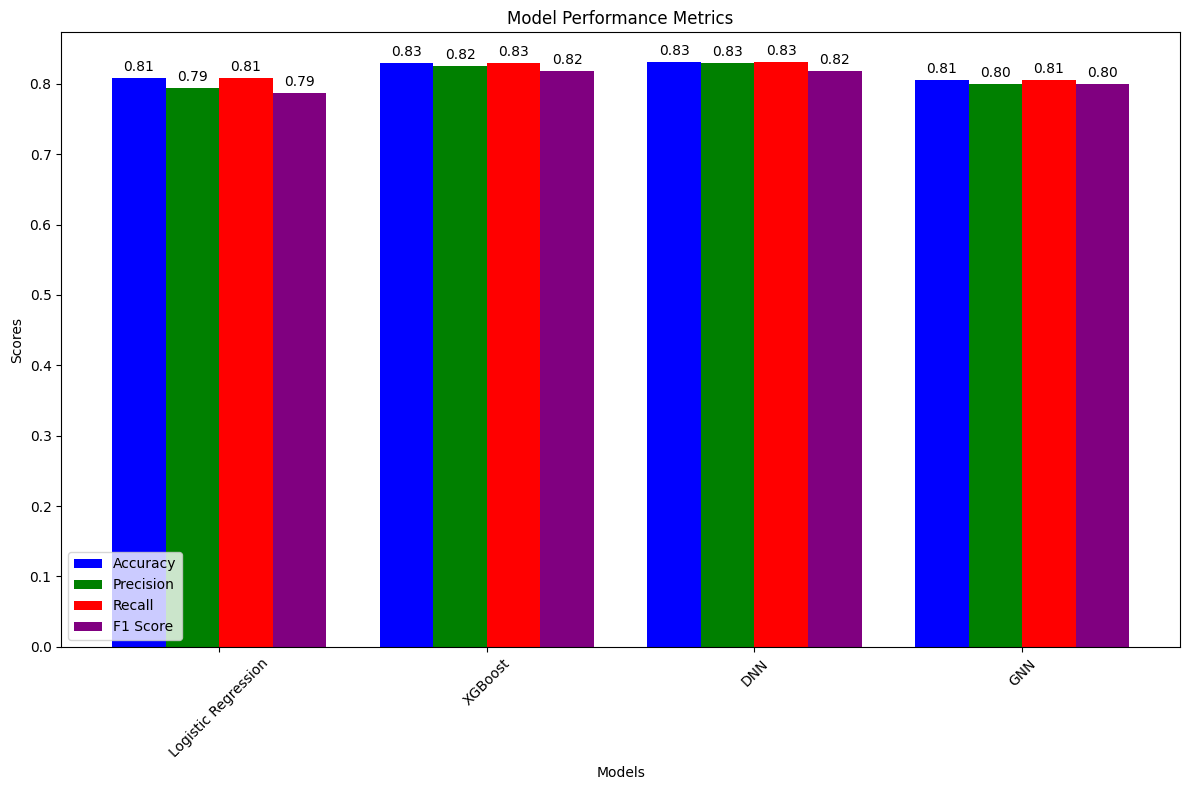

In [26]:
# Graph the results
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'XGBoost', 'DNN', 'GNN']
accuracy = [lr_accuracy, xbg_accuracy, dnn_accuracy, gnn_accuracy]
precision = [lr_precision, xbg_precision, dnn_precision, gnn_precision]
recall = [lr_recall, xbg_recall, dnn_recall, gnn_recall]
f1 = [lr_f1, xbg_f1, dnn_f1, gnn_f1]
# Create a grouped bar chart
bar_width = 0.2
x = range(len(models))

plt.figure(figsize=(12, 8))

# Plot accuracy
plt.bar([p - 1.5 * bar_width for p in x], accuracy, width=bar_width, color='blue', align='center', label='Accuracy')
for i, v in enumerate(accuracy):
    plt.text(i - 1.5 * bar_width, v + 0.01, f"{v:.2f}", ha='center')

# Plot precision
plt.bar([p - 0.5 * bar_width for p in x], precision, width=bar_width, color='green', align='center', label='Precision')
for i, v in enumerate(precision):
    plt.text(i - 0.5 * bar_width, v + 0.01, f"{v:.2f}", ha='center')

# Plot recall
plt.bar([p + 0.5 * bar_width for p in x], recall, width=bar_width, color='red', align='center', label='Recall')
for i, v in enumerate(recall):
    plt.text(i + 0.5 * bar_width, v + 0.01, f"{v:.2f}", ha='center')

# Plot F1 score
plt.bar([p + 1.5 * bar_width for p in x], f1, width=bar_width, color='purple', align='center', label='F1 Score')
for i, v in enumerate(f1):
    plt.text(i + 1.5 * bar_width, v + 0.01, f"{v:.2f}", ha='center')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()